Part of course work Data Analytics for cyber security 

![](https://i.imgur.com/eBRPvWB.png)

# Practical PyTorch: Generating Names with a Conditional Character-Level RNN
[Based on this github](https://github.com/spro/practical-pytorch/blob/master/conditional-char-rnn/conditional-char-rnn.ipynb) and this Pytorch [tutorial](https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html) "NLP FROM SCRATCH: GENERATING NAMES WITH A CHARACTER-LEVEL RNN"

We're going to use a RNN to generate passwords.

# Reading the Data

We'll open the file from the Google Drive

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker
EOS = n_letters - 1


# Read a file and split into lines
def read_lines(filename):
    lines = open(filename).read().strip().split('\n')
    return lines

# Build the category_lines dictionary, a list of lines per category
category_lines = {}
all_categories = []
category = "passwords"
all_categories.append(category)
lines = read_lines("/content/drive/My Drive/common-passwords.txt")
category_lines[category] = lines

n_categories = len(all_categories)

print('# categories:', n_categories, all_categories)

# categories: 1 ['passwords']


# Creating the Network

This network extends [the last tutorial's RNN](#Creating-the-Network) with an extra argument for the category tensor, which is concatenated along with the others. The category tensor is a one-hot vector just like the letter input. (We don't need this, so everything will be category 1).

We will interpret the output as the probability of the next letter. When sampling, the most likely output letter is used as the next input letter.

I added a second linear layer `o2o` (after combining hidden and output) to give it more muscle to work with. There's also a dropout layer, which [randomly zeros parts of its input](https://arxiv.org/abs/1207.0580) with a given probability (here 0.1) and is usually used to fuzz inputs to prevent overfitting. Here we're using it towards the end of the network to purposely add some chaos and increase sampling variety.

![](https://i.imgur.com/jzVrf7f.png)

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(1, self.hidden_size))

# Preparing for Training

First of all, helper functions to get random pairs of (category, line):

In [ ]:
import random

# Get a random category and random line from that category
def random_training_pair():
    category = random.choice(all_categories)
    line = random.choice(category_lines[category])
    return category, line

For each timestep (that is, for each letter in a training word) the inputs of the network will be `(category, current letter, hidden state)` and the outputs will be `(next letter, next hidden state)`. So for each training set, we'll need the category, a set of input letters, and a set of output/target letters.

Since we are predicting the next letter from the current letter for each timestep, the letter pairs are groups of consecutive letters from the line - e.g. for `"ABCD<EOS>"` we would create ("A", "B"), ("B", "C"), ("C", "D"), ("D", "EOS").

![](https://i.imgur.com/JH58tXY.png)

The category tensor is a [one-hot tensor](https://en.wikipedia.org/wiki/One-hot) of size `<1 x n_categories>`. When training we feed it to the network at every timestep - this is a design choice, it could have been included as part of initial hidden state or some other strategy.

In [ ]:
# One-hot vector for category
def make_category_input(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return Variable(tensor)

# One-hot matrix of first to last letters (not including EOS) for input
def make_chars_input(chars):
    tensor = torch.zeros(len(chars), n_letters)
    for ci in range(len(chars)):
        char = chars[ci]
        tensor[ci][all_letters.find(char)] = 1
    tensor = tensor.view(-1, 1, n_letters)
    return Variable(tensor)

# LongTensor of second letter to end (EOS) for target
def make_target(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    tensor = torch.LongTensor(letter_indexes)
    return Variable(tensor)

For convenience during training we'll make a `random_training_set` function that fetches a random (category, line) pair and turns them into the required (category, input, target) tensors.

In [ ]:
# Make category, input, and target tensors from a random category, line pair
def random_training_set():
    category, line = random_training_pair()
    category_input = make_category_input(category)
    line_input = make_chars_input(line)
    line_target = make_target(line)
    return category_input, line_input, line_target

# Training the Network

In contrast to classification, where only the last output is used, we are making a prediction at every step, so we are calculating loss at every step.

The magic of autograd allows you to simply sum these losses at each step and call backward at the end. But don't ask me why initializing loss with 0 works.

In [ ]:
def train(category_tensor, input_line_tensor, target_line_tensor):
    hidden = rnn.init_hidden()
    optimizer.zero_grad()
    loss = 0
    
    for i in range(input_line_tensor.size()[0]):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        loss += criterion(output, torch.LongTensor([target_line_tensor[i]]))

    loss.backward()
    optimizer.step()
    
    return output, loss.data / input_line_tensor.size()[0]

To keep track of how long training takes I am adding a `time_since(t)` function which returns a human readable string:

In [ ]:
import time
import math

def time_since(t):
    now = time.time()
    s = now - t
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)
r=(random_training_set())
print(r)
import string
y=string.ascii_letters
# this prints all the letters except the first one. Look at the first tensor for that
for c in range(len(r[2])-1):
  print(y[r[2][c]],end='')

(tensor([[1.]]), tensor([[[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

Training is business as usual - call train a bunch of times and wait a few minutes, printing the current time and loss every `print_every` epochs, and keeping store of an average loss per `plot_every` epochs in `all_losses` for plotting later.

In [ ]:
loss = nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
output = loss(input, target)
print(input)
print(target)
print(output)

tensor([[ 0.3309,  0.4256, -1.0290,  0.3549,  0.5104],
        [ 0.1718,  0.6619, -0.4747, -0.0436,  0.1400],
        [ 0.5625,  0.6880, -1.5031, -0.1491, -0.7729]], requires_grad=True)
tensor([0, 3, 0])
tensor(1.4785, grad_fn=<NllLossBackward>)


In [ ]:
n_epochs = 15000
print_every = 1000
plot_every = 500
all_losses = []
loss_avg = 0 # Zero every plot_every epochs to keep a running average
learning_rate = 0.0005

rnn = RNN(n_letters, 128, n_letters)
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

start = time.time()

for epoch in range(1, n_epochs + 1):
    output, loss = train(*random_training_set())
    loss_avg += loss
    
    if epoch % print_every == 0:
        print('%s (%d %d%%) %.4f' % (time_since(start), epoch, epoch / n_epochs * 100, loss))

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

0m 3s (1000 6%) 2.5689
0m 6s (2000 13%) 2.7728
0m 10s (3000 20%) 2.0891
0m 13s (4000 26%) 2.2937
0m 16s (5000 33%) 2.8090
0m 19s (6000 40%) 2.3829
0m 23s (7000 46%) 1.8066
0m 26s (8000 53%) 2.4225
0m 29s (9000 60%) 2.1141
0m 32s (10000 66%) 1.5909
0m 36s (11000 73%) 2.5334
0m 39s (12000 80%) 2.7845
0m 42s (13000 86%) 3.4781
0m 45s (14000 93%) 2.2589
0m 49s (15000 100%) 2.3897


# Plotting the Network

Plotting the historical loss from all_losses shows the network learning:

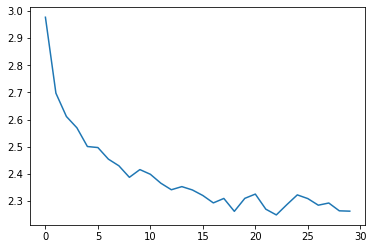

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

# Sampling the Network

To sample we give the network a letter and ask what the next one is, feed that in as the next letter, and repeat until the EOS token.

* Create tensors for input category, starting letter, and empty hidden state
* Create a string `output_str` with the starting letter
* Up to a maximum output length,
    * Feed the current letter to the network
    * Get the next letter from highest output, and next hidden state
    * If the letter is EOS, stop here
    * If a regular letter, add to `output_str` and continue
* Return the final name

*Note*: Rather than supplying a starting letter every time we generate, we could have trained with a "start of string" token and had the network choose its own starting letter.

In [ ]:
max_length = 20

# Generate given a category and starting letter
def generate_one(category, start_char='A', temperature=0.5):
    category_input = make_category_input(category)
    chars_input = make_chars_input(start_char)
    hidden = rnn.init_hidden()

    output_str = start_char
    
    for i in range(max_length):
        output, hidden = rnn(category_input, chars_input[0], hidden)
        
        # Sample as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Stop at EOS, or add to output_str
        if top_i == EOS:
            break
        else:    
            char = all_letters[top_i]
            output_str += char
            chars_input = make_chars_input(char)

    return output_str

# Get multiple samples from one category and multiple starting letters
def generate(category, start_chars='ABC'):
    for start_char in start_chars:
        print(generate_one(category, start_char))

In [ ]:
generate('passwords', 'r')

rale


In [ ]:
generate('passwords', 'pas')

porgin
anaw
shersonx


In [ ]:
generate('passwords', 'abc')

arala
bark
cordatco


In [ ]:
generate('passwords', 'abc')

arach
barad
chande
